## 0. Simulate some data and fit an emulator

In [1]:
import torch

from autoemulate.experimental.simulations.projectile import ProjectileMultioutput
from autoemulate.experimental.emulators.gaussian_process.exact import (
    GaussianProcessExact,
)

In [2]:
sim = ProjectileMultioutput()
x = sim.sample_inputs(1000)
y = sim.forward_batch(x)

Running simulations: 100%|██████████| 1000/1000 [00:00<00:00, 1295.32it/s]

Successfully completed 1000/1000 simulations (100.0%)


In [3]:
gp = GaussianProcessExact(x, y)
gp.fit(x, y)

## 1. Simple HMC example.

In [4]:
from autoemulate.experimental.calibration.hmc import MCMC_calibration

Start with an "observation" that the GP has been trained on. 

Specifically, we will pretend we have N noisy experimental measurements. We should be able to recover the input parameters.

In [5]:
idx = -1 # which simulated value to pick
n_obs = 10
noise_scale = 0.05 # set noise as some ratio of the observed value

observations = {
    "distance": y[idx, 0].repeat(n_obs) + torch.rand(n_obs) * noise_scale * y[idx, 0], 
    "impact_velocity": y[idx, 1].repeat(n_obs) + torch.rand(n_obs) * noise_scale * y[idx, 1]
}
observations

{'distance': tensor([17272.2229, 16848.7465, 17054.4543, 17158.3243, 17291.2650, 17169.7262,
         16743.0384, 16787.0097, 17079.0198, 17204.4318], dtype=torch.float64),
 'impact_velocity': tensor([293.7253, 291.2057, 286.5963, 291.6869, 293.3136, 297.1105, 298.2162,
         294.0742, 294.6239, 297.5578], dtype=torch.float64)}

In [6]:
# use the simulator parameter_range 
hmc = MCMC_calibration(gp, sim.parameters_range, observations, 10.0)

Run MCMC (note that below we have set the number of MCMC steps to a very low number, don't expect convergence).

In [ ]:
mcmc = hmc.run(
    warmup_steps=50, 
    num_samples=200,
    sampler='hmc',
    step_size=1
    # also init with x values matching "observations"
    )

Warmup:   3%|▎         | 7/250 [00:11,  2.09s/it, step size=3.82e-04, acc. prob=0.429]

The returned Pyro MCMC object has methods for accessing the generated samples (`mcmc.get_samples()`) or, as shown below, to get their summary statistics.

In [ ]:
mcmc.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         c     -0.54      0.13     -0.56     -0.70     -0.41     12.09      1.21
        v0    176.26     82.13    141.89     94.42    325.31      6.61      1.11

Number of divergences: 13


## 2. Plotting with Arviz

We have an option to turn the MCMC object into an Arviz object, which can be passed to any of their plotting function.

In [ ]:
import arviz as az

In [ ]:
az_data = hmc.to_arviz(mcmc, posterior_predictive=True)

KeyError: 'divergences'

array([[<Axes: title={'center': 'c'}>, <Axes: title={'center': 'c'}>],
       [<Axes: title={'center': 'v0'}>, <Axes: title={'center': 'v0'}>]],
      dtype=object)

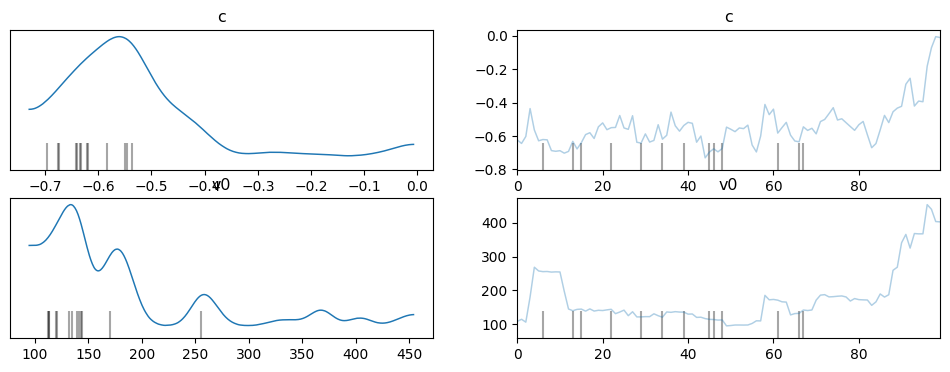

In [ ]:
az.plot_trace(az_data)

<Axes: xlabel='c', ylabel='v0'>

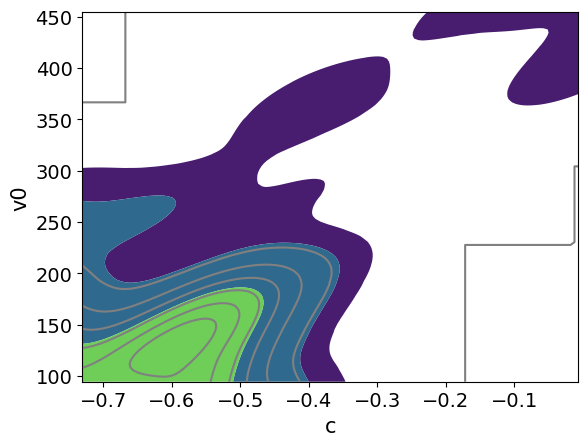

In [ ]:
az.plot_pair(az_data, kind='kde')

array([<Axes: xlabel='distance'>, <Axes: xlabel='impact_velocity'>],
      dtype=object)

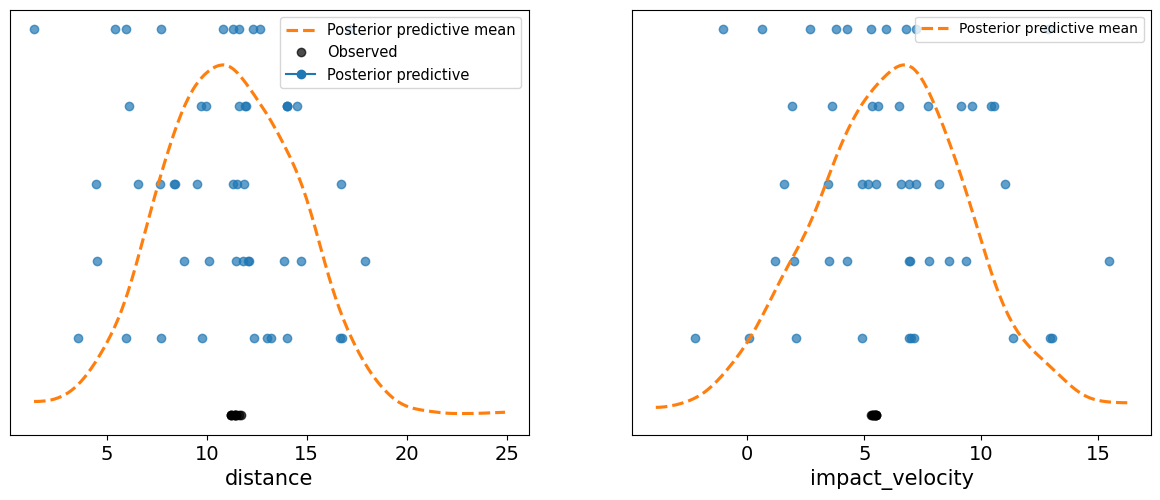

In [ ]:
az.plot_ppc(az_data, kind='scatter')

In [ ]:
az.plot_autocorr(az_data)

NameError: name 'az_data' is not defined

## 3. Use sensitivity analysis and history matching to refine problem before running HMC.

The `MCMC_calibration` object has an option to provide a list of parameters to calibrate. A common approach is to select these based on results of `SensitivityAnalysis`.

Similarly, the user provides parameter ranges from withing which to sample parameter values. This can be simply the range of the simulator. Alternatively, one can use `HistoryMatching` to reduce the parameter range and pass that to the `MCMC_calibration` instead. 

Below we demonstrate how to do both.

In [ ]:
from autoemulate.experimental.sensitivity_analysis import SensitivityAnalysis
from autoemulate.experimental.calibration.history_matching import HistoryMatching

1. Run sensitivity analysis and get top N parameters (here we just get the top 1).

In [ ]:
problem = {
        "num_vars": 2,
        "names": sim.param_names,
        "bounds": sim.param_bounds,
    }

sa = SensitivityAnalysis(gp, problem=problem)
df = sa.run("sobol")

top_param = sa.top_n_sobol_params(df, 1)

# the output is just a list of strings, this could be set by hand
top_param

/Users/mfamili/work/autoemulate/.venv/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/Users/mfamili/work/autoemulate/.venv/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


['v0']

2. Run history matching and generate new parameter bounds from NROY samples (if get any).

In [ ]:
# start with some GP predictions
x_new = sim.sample_inputs(20)
output = gp.predict(torch.tensor(x_new, dtype=torch.float32))
pred_means, pred_vars = (
    output.mean.float().detach(),
    output.variance.float().detach(),
)

/var/folders/69/k2h9t9xd2h36f2pn42ddssz40000gr/T/ipykernel_7427/3687513851.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = gp.predict(torch.tensor(x_new, dtype=torch.float32))


In [ ]:
# generate NROY samples
hm = HistoryMatching(
    # take mean of observations and add noise
    observations={k: [v.mean(), 10.0] for k,v in observations.items()},
    threshold=5.0,
    rank=2
)
implausability = hm.calculate_implausibility(pred_means, pred_vars)
nroy_samples = hm.get_nroy(implausability, x_new)
nroy_samples

tensor([], size=(0, 2))

The newly generated range is slightly narrower than the range of the simulator.

In [ ]:
# get new param bounds
nroy_param_range = hm.generate_param_bounds(nroy_samples, param_names = sim.param_names)
nroy_param_range

3. Pass results to the `MCMC_calibration` object.

In [ ]:
hmc_nroy = MCMC_calibration(
    gp, 
    nroy_param_range if nroy_param_range is not None else sim.parameters_range, 
    observations, 
    10.0,
    top_param
    )

In [ ]:
mcmc_nroy = hmc_nroy.run(warmup_steps=10, num_samples=100)

Sample: 100%|██████████| 110/110 [00:00, 110.91it/s, step size=9.75e-05, acc. prob=0.337]


In [ ]:
mcmc_nroy.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
        v0    839.65      1.75    839.62    837.14    841.36      2.90      2.10

Number of divergences: 98
